(glue/main)=

# Saving variables to embed (glue)

The `glue` submodule allows you to store variables in the notebooks outputs, by keys,
then reference those keys to embed the outputs inline of your text content.[^download]

[^download]: This notebook can be downloaded as **{nb-download}`glue.ipynb`** and {download}`glue.md`

:::{versionchanged} 0.14.0
The `glue` roles and directives now only identify keys in the same notebook, by default.
To glue keys from other notebooks, see {ref}`glue/crossdoc`.
:::

(glue/gluing)=

## Save variables in code cells

You can use `myst_nb.glue()` to assign the output of a variable to a key of your choice.
`glue` will store all of the information that is normally used to display that variable (ie, whatever happens when you display the variable by putting it at the end of a cell).
Choose a key that you will remember, as you will use it later.

The following code glues a variable inside the notebook:

In [1]:
from myst_nb import glue
a = "my variable!"
glue("my_variable", a)

'my variable!'

You can then insert it into your text like so: {glue}`my_variable`.

That was accomplished with the following code: `` {glue}`my_variable` ``.

### Saving different variable types

You can glue anything in your notebook and display it later with `{glue}`.
Here we'll show how to glue and paste **numbers and images**.
We'll simulate some data and run a simple bootstrap on it.
We'll hide most of this process below, to focus on the glueing part.

In [2]:
# Simulate some data and bootstrap the mean of the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

n_points = 10000
n_boots = 1000
mean, sd = (3, .2)
data = sd*np.random.randn(n_points) + mean
bootstrap_indices = np.random.randint(0, n_points, n_points*n_boots).reshape((n_boots, n_points))

In the cell below, `data` contains our data, and `bootstrap_indices` is a collection of sample indices in each bootstrap.
Below we'll calculate a few statistics of interest, and `glue()` them into the notebook.

In [3]:
# Calculate the mean of a bunch of random samples
means = data[bootstrap_indices].mean(0)
# Calcualte the 95% confidence interval for the mean
clo, chi = np.percentile(means, [2.5, 97.5])

# Store the values in our notebook
glue("boot_mean", means.mean())
glue("boot_clo", clo)
glue("boot_chi", chi)

2.9979867459489187

2.9857391514041267

3.010283381474472

By default, `glue` will display the value of the variable you are gluing.
This is useful for sanity-checking its value at glue-time.
If you'd like to **prevent display**, use the `display=False` option.
Note that below, we also *overwrite* the value of `boot_chi` (but using the same value):

In [4]:
glue("boot_chi_notdisplayed", chi, display=False)

You can also glue visualizations, such as matplotlib figures (here we use `display=False` to ensure that the figure isn't plotted twice):

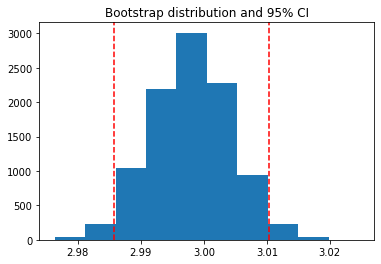

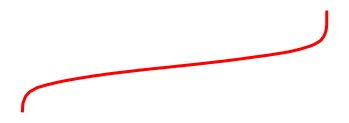

In [5]:
# Visualize the historgram with the intervals
fig, ax = plt.subplots()
ax.hist(means)
for ln in [clo, chi]:
    ax.axvline(ln, ls='--', c='r')
ax.set_title("Bootstrap distribution and 95% CI")

# And a wider figure to show a timeseries
fig2, ax = plt.subplots(figsize=(6, 2))
ax.plot(np.sort(means), lw=3, c='r')
ax.set_axis_off()

glue("boot_fig", fig, display=False)
glue("sorted_means_fig", fig2, display=False)

The same can be done for DataFrames (or other table-like objects) as well.

In [6]:
bootstrap_subsets = data[bootstrap_indices][:3, :5].T
df = pd.DataFrame(bootstrap_subsets, columns=["first", "second", "third"])
glue("df_tbl", df)

,first,second,third
0,2.906634,3.073127,2.699824
1,3.103828,2.872757,2.786053
2,3.229084,3.040184,2.848645
3,2.886814,2.787425,3.061775
4,2.990553,3.135287,3.117826


```{tip}
Since we are going to paste this figure into our document at a later point,
you may wish to remove the output here, using the `remove-output` tag
(see {ref}`use/removing`).
```

(glue/pasting)=

## Embedding variables in the page

Once you have glued variables into a notebook, you can then **paste**
those variables into your text in your book anywhere you like (even on other pages).
These variables can be pasted using one of the roles or directives in the `glue:` *family*.

### The `glue` role/directive

The simplest role and directive are `glue` (a.k.a. `glue:any`),
which paste the glued output inline or as a block respectively,
with no additional formatting.
Simply add:

````
```{glue} your-key
```
````

For example, we'll paste the plot we generated above with the following text:

````md
```{glue} boot_fig
```
````

Here's how it looks:

```{glue} boot_fig
```

Or we can paste inline objects like so:

```md
Inline text; {glue}`boot_mean`, and figure; {glue}`boot_fig`.
```

Inline text; {glue}`boot_mean`, and figure; {glue}`boot_fig`.

```{tip}
We recommend using wider, shorter figures when plotting in-line, with a ratio
around 6x2. For example, here's is an in-line figure of sorted means
from our bootstrap: {glue}`sorted_means_fig`.
It can be used to make a visual point that isn't too complex! For more
ideas, check out [how sparklines are used](https://en.wikipedia.org/wiki/Sparkline).
```

Next we'll cover some more specific pasting functionality, which gives you more
control over how the outputs look in your pages.

## Controlling the output format

You can control the pasted outputs by using a sub-command of `{glue}`.
These are called like so: `` {glue:subcommand}`key` ``.
These subcommands allow you to control more of the look, feel, and content of the pasted output.

```{tip}
When you use `{glue}` you are actually using a short-hand for `{glue:any}`. This is a
generic command that doesn't make many assumptions about what you are gluing.
```

### The `glue:text` role

The `glue:text` role, is specific to `text/plain` outputs.
For example, the following text:

```md
The mean of the bootstrapped distribution was {glue:text}`boot_mean` (95% confidence interval {glue:text}`boot_clo`/{glue:text}`boot_chi`).
```

Is rendered as:

The mean of the bootstrapped distribution was {glue:text}`boot_mean` (95% confidence interval {glue:text}`boot_clo`/{glue:text}`boot_chi`)

```{note}
`glue:text` only works with glued variables that contain a `text/plain` output.
```

With `glue:text` we can add formatting to the output, by specifying a format spec string after a `:`: `` {glue:text}`mykey:<format_spec>` ``

The `<format_spec>` should be a valid [Python format specifier](https://docs.python.org/3/library/string.html#format-specification-mini-language).

This is particularly useful if you are displaying numbers and want to round the results.
For example, the following: ``My rounded mean: {glue:text}`boot_mean:.2f` `` will be rendered like this:

My rounded mean: {glue:text}`boot_mean:.2f` (95% CI: {glue:text}`boot_clo:.2f`/{glue:text}`boot_chi:.2f`).

### The `glue:figure` directive

With `glue:figure` you can apply more formatting to figure like objects,
such as giving them a caption and referenceable label:

:::{table} `glue:figure` directive options
| Option | Type | Description |
| ------ | ---- | ----------- |
| alt | text | Alternate text of an image |
| height | length | The desired height of an image |
| width | length or percentage | The width of an image |
| scale | percentage | The uniform scaling factor of an image |
| class | text | A space-separated list of class names for the image |
| figwidth | length or percentage | The width of the figure |
| figclass | text | A space-separated list of class names for the figure |
| align | text | left, center, or right |
| name | text | referenceable label for the figure |
:::

````md
```{glue:figure} boot_fig
:alt: "Alternative title"
:figwidth: 300px
:name: "fig-boot"

This is a **caption**, with an embedded `{glue:text}` element: {glue:text}`boot_mean:.2f`!
```
````

```{glue:figure} boot_fig
:alt: "Alternative title"
:figwidth: 300px
:name: "fig-boot"

This is a **caption**, with an embedded `{glue:text}` element: {glue:text}`boot_mean:.2f`!
```

```md
Here is a {ref}`reference to the figure <fig-boot>`
```

Here is a {ref}`reference to the figure <fig-boot>`

Here's a table:

````md
```{glue:figure} df_tbl
:figwidth: 300px
:name: "tbl:df"

A caption for a pandas table.
```

````
```{glue:figure} df_tbl
:figwidth: 300px
:name: "tbl:df"

A caption for a pandas table.
```

### The `glue:math` directive

The `glue:math` directive, is specific to latex math outputs
(glued variables that contain a `text/latex` mimetype),
and works similarly to the [sphinx math directive](https://www.sphinx-doc.org/en/1.8/usage/restructuredtext/directives.html#math).

:::{table} `glue:math` directive options
| Option | Type | Description |
| ------ | ---- | ----------- |
| nowrap | flag | Prevent any wrapping of the given math in a math environment |
| class | text | A space-separated list of class names |
| label or name | text | referenceable label for the figure |
:::

In [7]:
import sympy as sym
f = sym.Function('f')
y = sym.Function('y')
n = sym.symbols(r'\alpha')
f = y(n)-2*y(n-1/sym.pi)-5*y(n-2)
glue("sym_eq", sym.rsolve(f,y(n),[1,4]))

(sqrt(5)*I)**\alpha*(1/2 - 2*sqrt(5)*I/5) + (-sqrt(5)*I)**\alpha*(1/2 + 2*sqrt(5)*I/5)

````md
Insert the equation here:

```{glue:math} sym_eq
:label: eq-sym
```

Which we reference as Equation {eq}`eq-sym`
````

Insert the equation here:

```{glue:math} sym_eq
:label: eq-sym
```

Which we reference as Equation {eq}`eq-sym`.

```{note}
`glue:math` only works with glued variables that contain a `text/latex` output.
```

### The `glue:md` role/directive

With `glue:md`, you can output `text/markdown`, that will be integrated into your page.

In [8]:
from IPython.display import Markdown
glue("inline_md", Markdown(
  "inline **markdown** with a [link](glue/main), "
  "and a nested glue value: {glue}`boot_mean`"
), display=False)
glue("block_md", Markdown("""
#### A heading

Then some text, and anything nested.

```python
print("Hello world!")
```
"""
), display=False)

The format of the markdown can be specified as:

- `commonmark` (default): Restricted to the [CommonMark specification](https://commonmark.org/).
- `gfm`: Restricted to the [GitHub-flavored markdown](https://github.github.com/gfm/).
  - Note, this requires the installation of the [linkify-it-py package](https://pypi.org/project/linkify-it-py)
- `myst`: The MyST parser configuration for the the current document.

For example, the following role/directive will glue inline/block MyST Markdown, as if it was part of the original document.

````md
Here is some {glue:md}`inline_md:myst`!

```{glue:md} block_md
:format: myst
```
````

Here is some {glue:md}`inline_md:myst`!

```{glue:md} block_md
:format: myst
```

(glue/crossdoc)=
## Embedding outputs from other pages

Certain `glue` roles and directives can be used to paste content from other notebooks,
by specifying the (relative) path to them.

:::{tip}
Sometimes you'd like to use variables from notebooks that are not meant to be shown to users.
In this case, you should bundle the notebook with the rest of your content pages, but include `orphan: true` in the metadata of the notebook.
:::

For example, the following example pastes glue variables from {ref}`orphaned-nb`:

````markdown
- A cross-pasted `any` role: {glue}`orphaned_nb.ipynb::var_text`
- A cross-pasted `text` role: {glue:text}`orphaned_nb.ipynb::var_float:.2E`

A cross-pasted `any` directive:

```{glue} var_text
:doc: orphaned_nb.ipynb
```
````

- A cross-pasted `any` role: {glue}`orphaned_nb.ipynb::var_text`
- A cross-pasted `text` role: {glue:text}`orphaned_nb.ipynb::var_float:.2E`

A cross-pasted `any` directive:

```{glue} var_text
:doc: orphaned_nb.ipynb
```

## Advanced use-cases

Here are a few more specific and advanced uses of the `glue` submodule.

### Embedding into tables

In addition to pasting blocks of outputs, or in-line with text, you can also paste directly
into tables. This allows you to compose complex collections of structured data using outputs
that were generated in other notebooks. For example the following table:

````md
| name                            |       plot                  | mean                      | ci                                                 |
|:-------------------------------:|:---------------------------:|---------------------------|----------------------------------------------------|
| histogram and raw text          | {glue}`boot_fig`           | {glue}`boot_mean`        | {glue}`boot_clo`-{glue}`boot_chi`                |
| sorted means and formatted text | {glue}`sorted_means_fig`   | {glue:text}`boot_mean:.3f`| {glue:text}`boot_clo:.3f`-{glue:text}`boot_chi:.3f`|
````

Results in:

| name                            |       plot                  | mean                      | ci                                                |
|:-------------------------------:|:---------------------------:|---------------------------|---------------------------------------------------|
| histogram and raw text          | {glue}`boot_fig`             | {glue}`boot_mean`          | {glue}`boot_clo`-{glue}`boot_chi`                   |
| sorted means and formatted text | {glue}`sorted_means_fig`     | {glue:text}`boot_mean:.3f` | {glue:text}`boot_clo:.3f`-{glue:text}`boot_chi:.3f` |